# In this notebook we fit a SEIR model with hidden states to the Moscow Covid-19 data

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib

In [50]:
sns.set()
%matplotlib inline

In [51]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%autoreload 2

In [53]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_on_select_dates_and_k_days_ahead

# Load data

In [54]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

In [7]:
df['date'] = pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D')

In [8]:
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


In [9]:
df[df.total_dead > 0].head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
13,2020-03-25,410,14,2,2,120,5,394,217.00000,7.71429,0.28571,0.28571,46.28571,1.85714,209.00000
14,2020-03-26,546,15,2,0,136,1,529,281.00000,9.71429,0.57143,0.28571,64.00000,2.00000,270.71429
15,2020-03-27,703,18,3,1,157,3,682,362.71429,11.57143,1.00000,0.42857,81.71429,1.85714,350.14286
16,2020-03-28,817,18,5,2,114,0,794,459.85714,13.00000,1.71429,0.71429,97.14286,1.42857,445.14286
17,2020-03-29,1014,28,6,1,197,10,980,577.42857,15.85714,2.57143,0.85714,117.57143,2.85714,559.00000


# Model

In [10]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= '2021-01-10')]

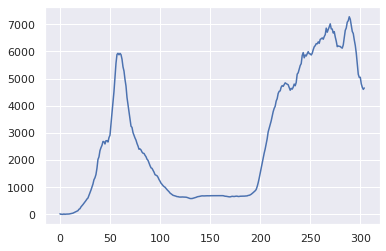

In [11]:
train_subset.infected_per_day_ma7.plot()
plt.show()

In [12]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

305   2021-01-11
306   2021-01-12
307   2021-01-13
Name: date, dtype: datetime64[ns]

In [13]:
train_subset.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
0,2020-03-12,21,0,0,0,21,0,21,21.0,0.0,0.0,0.0,21.0,0.0,21.0
1,2020-03-13,26,0,0,0,5,0,26,26.0,0.0,0.0,0.0,5.0,0.0,26.0
2,2020-03-14,35,0,0,0,9,0,35,35.0,0.0,0.0,0.0,9.0,0.0,35.0
3,2020-03-15,35,1,0,0,0,1,34,35.0,1.0,0.0,0.0,0.0,1.0,34.0
4,2020-03-16,53,1,0,0,18,0,52,53.0,1.0,0.0,0.0,18.0,0.0,52.0


In [14]:
model = joblib.load('seir_hidden_moscow.pkl')
model.params

name,value,initial value,min,max,vary,expression,brute step
population,12000000.0,12000000,-inf,inf,False,,None
sigmoid_r,20.0000000,20,1.00000000,30.0000000,False,,1.00000000
sigmoid_c,0.50000000,0.5,0.00000000,1.00000000,False,,0.10000000
epidemic_started_days_ago,10.0000000,10,1.00000000,90.0000000,False,,10.0000000
r0,4.78139479,4,3.00000000,5.00000000,True,,0.05000000
alpha,0.00640000,0.0064,0.00500000,0.00780000,True,,5.0000e-04
delta,0.49969140,0.3333333333333333,0.07142857,0.50000000,True,,None
gamma,0.11111111,0.1111111111111111,0.07142857,0.14285714,False,,None
rho,0.11111111,0.1111111111111111,-inf,inf,False,gamma,None
incubation_days,2.00123517,3.0,-inf,inf,False,1/delta,None


In [15]:
# stepwize_size = 60

# weights = {
#     'I': 0.25,
#     'R': 0.25,
#     'D': 0.5,
# }
# model = SEIRHidden(stepwise_size=stepwize_size)
# fitter = HiddenCurveFitter(
#      new_deaths_col='deaths_per_day_ma7',
#      new_cases_col='infected_per_day_ma7',
#      new_recoveries_col='recovered_per_day_ma7',
     
#      weights=weights,
#      max_iters=1000,
#      save_params_every=50,
# )
# fitter.fit(model, train_subset)

In [16]:
result = fitter.result
result

NameError: name 'fitter' is not defined

In [17]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

Incubation period: 2.00
Infectious period: 9.00


In [18]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [19]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

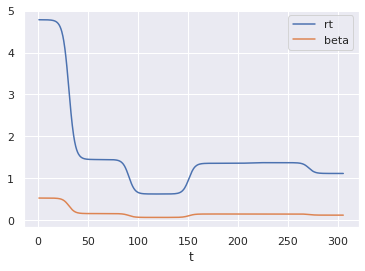

In [20]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

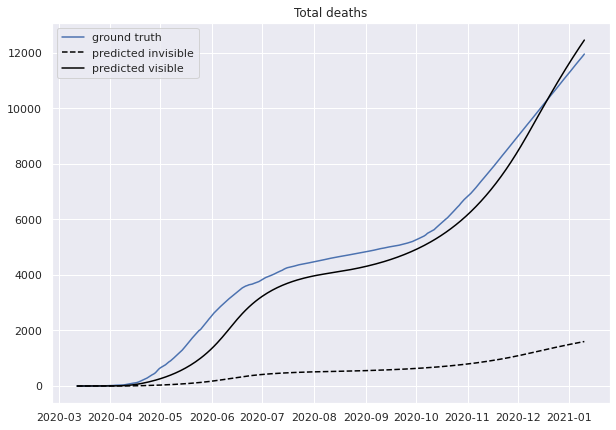

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

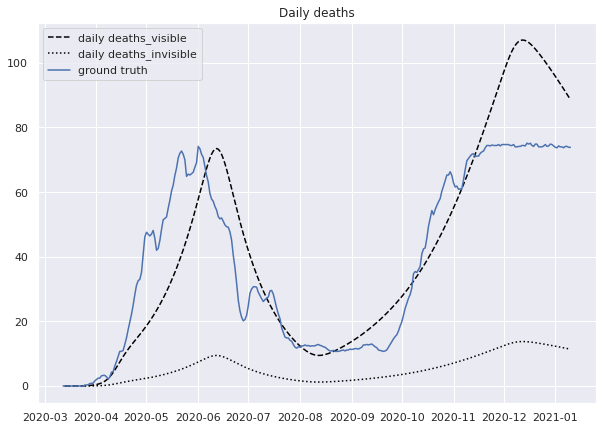

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(daily_df.new_dead_visible, label='daily deaths_visible', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_invisible, label='daily deaths_invisible', color='black', linestyle=':')
plt.plot(train_subset.date, train_subset['deaths_per_day_ma7'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

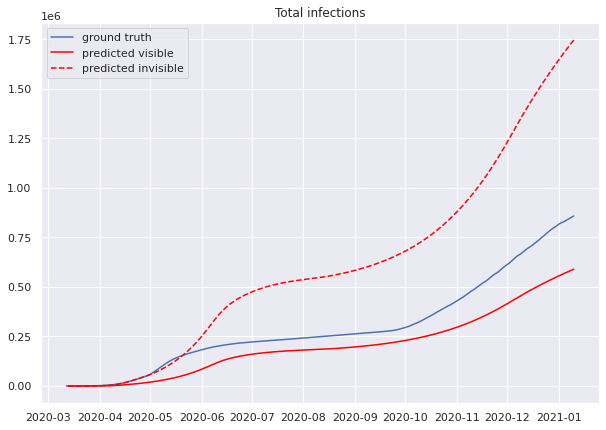

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='ground truth')
plt.plot(daily_df.new_infected_visible.cumsum(), label='predicted visible', color='red')
plt.plot(daily_df.new_infected_invisible.cumsum(), label='predicted invisible', color='red',  linestyle='dashed' )
plt.legend()
plt.title('Total infections')
plt.show()

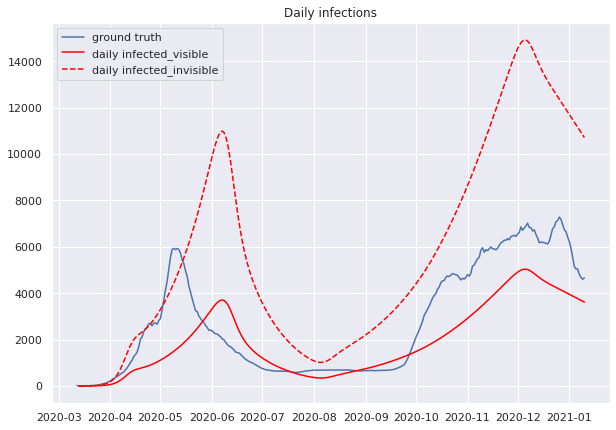

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day_ma7'], label='ground truth')

plt.plot(daily_df.new_infected_visible, label='daily infected_visible', color='red')
plt.plot(daily_df.new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Obtain forecast

In [25]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [26]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [27]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [28]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [29]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

In [30]:
test_daily_df = pd.DataFrame(
    {
        'date': test_subset.date[1:].values,
        'new_exposed': test_new_exposed,
        'new_infected_invisible': test_new_infected_invisible,
        'new_infected_visible': test_new_infected_visible,
        'new_recovered_invisible': test_new_recovered_invisible,
        'new_recovered_visible': test_new_recovered_visible,
        'new_dead_invisible': test_new_dead_invisible,
        'new_dead_visible': test_new_dead_visible
    },
    index=test_subset.date[1:])

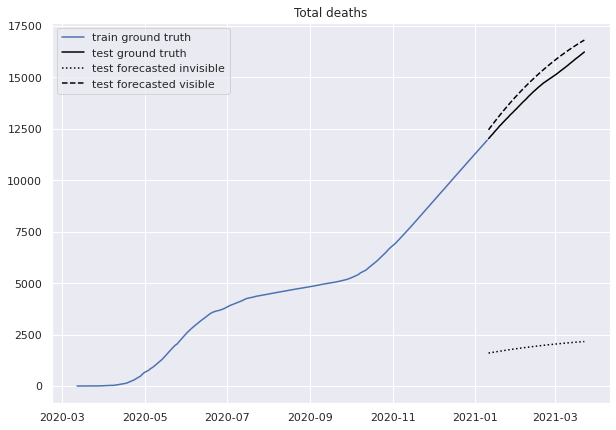

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='black')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='black', linestyle=':')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='black', linestyle='dashed')
plt.legend()
plt.title('Total deaths')
plt.show()

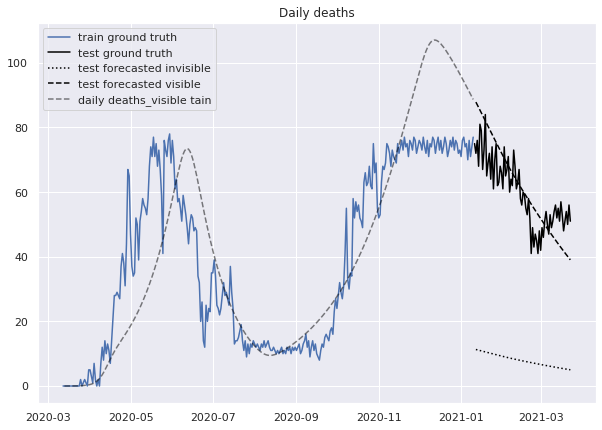

In [32]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')
plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')

plt.plot(test_daily_df.new_dead_invisible, label='test forecasted invisible', color='black', linestyle=':')
plt.plot(test_daily_df.new_dead_visible, label='test forecasted visible', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_visible, label='daily deaths_visible tain', color='black', alpha=0.5, linestyle='dashed')
plt.legend()
plt.title('Daily deaths')
plt.show()

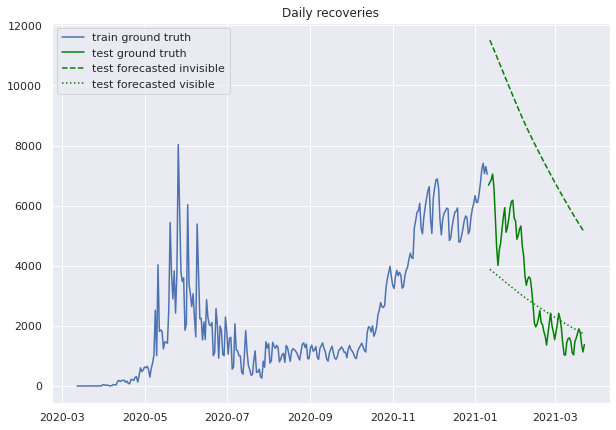

In [33]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_daily_df.new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_daily_df.new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

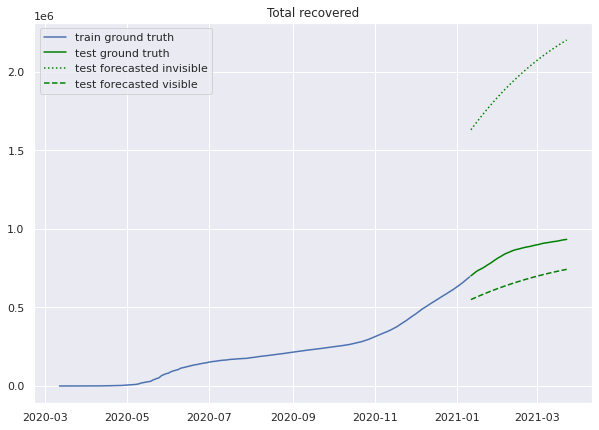

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='train ground truth')
plt.plot(test_subset.date, test_subset['total_recovered'], label='test ground truth', color='green')

plt.plot(test_subset.date, test_R, label='test forecasted invisible', color='green', linestyle=':')
plt.plot(test_subset.date, test_Rv, label='test forecasted visible', color='green', linestyle='dashed')
plt.legend()
plt.title('Total recovered')
plt.show()

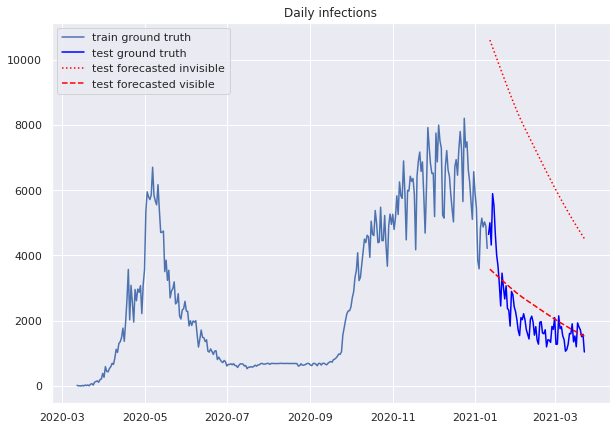

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['infected_per_day'], label='test ground truth', color='blue')
plt.plot(test_daily_df.new_infected_invisible, label='test forecasted invisible', color='red', linestyle=':')
plt.plot(test_daily_df.new_infected_visible, label='test forecasted visible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Train on full dataset and save

In [87]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, df)

In [88]:
fitter.result

In [89]:
pickle.dump(model, open('seir_hidden_moscow.pkl', 'wb'))

# Eval 30 days ahead on fixed dates

In [90]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-06-01', end=last_day)[::20]
len(eval_dates)

14

In [91]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [92]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  1.1min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  1.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  3.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  3.5min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  4.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  5.5min finished


In [93]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [94]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [95]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [96]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))

Mean overall error baseline 714.852
Mean overall error model 550.188


In [97]:
np.median(overall_errors_model)

537.3002818431886

In [98]:
from sir_models.utils import smape

In [99]:
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]
np.median(overall_smape_model)

0.04195470222773821

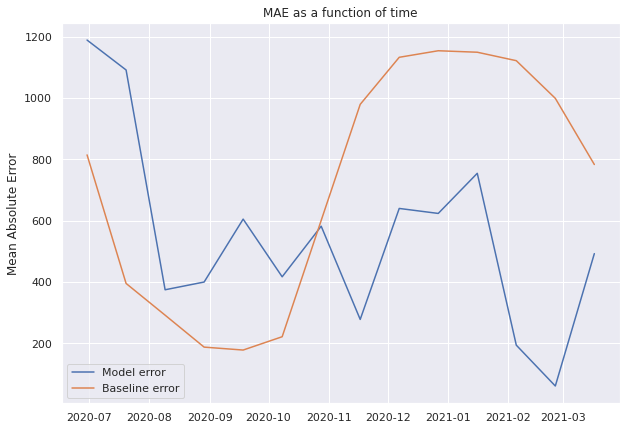

In [100]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model error')
plt.plot(x_dates, overall_errors_baseline, label='Baseline error')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.title('MAE as a function of time')
plt.show()

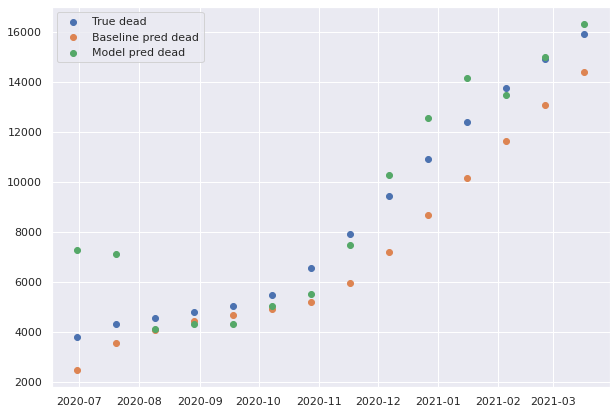

In [101]:
plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()

### Take a look on one prediction

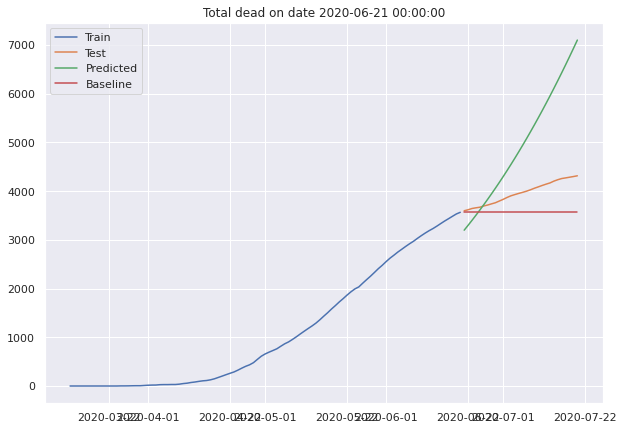

In [102]:
ix = np.random.choice(np.arange(len(train_dfs[-5:])))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [103]:
fitter.result

# Figures 

In [55]:
sns.set_context("talk")
sns.set_style("ticks")

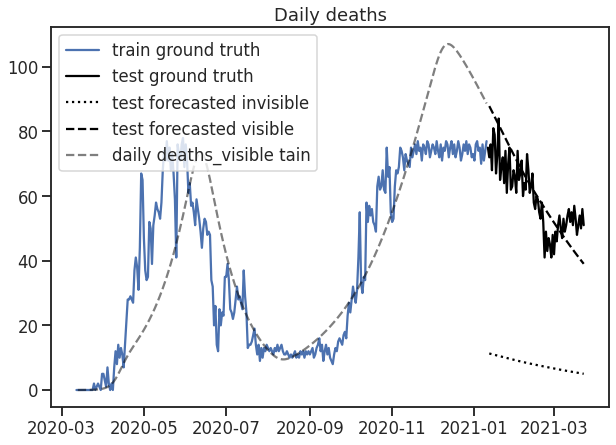

In [35]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')
plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')

plt.plot(test_daily_df.new_dead_invisible, label='test forecasted invisible', color='black', linestyle=':')
plt.plot(test_daily_df.new_dead_visible, label='test forecasted visible', color='black', linestyle='dashed')
plt.plot(daily_df.new_dead_visible, label='daily deaths_visible tain', color='black', alpha=0.5, linestyle='dashed')
plt.legend()
plt.title('Daily deaths')
plt.show()

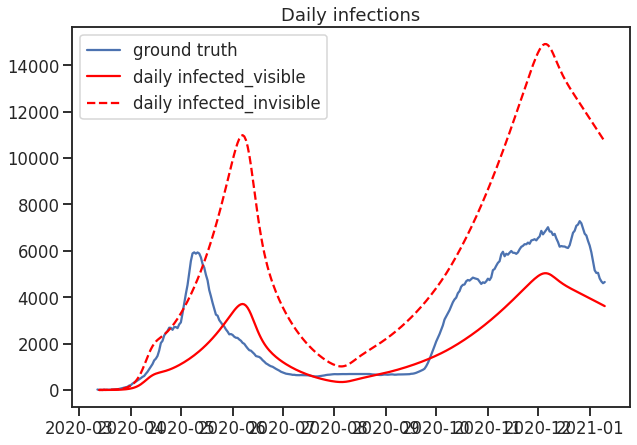

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day_ma7'], label='ground truth')

plt.plot(daily_df.new_infected_visible, label='daily infected_visible', color='red')
plt.plot(daily_df.new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

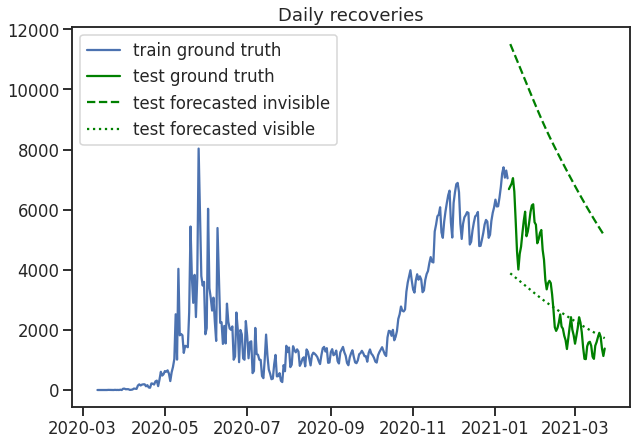

In [37]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_daily_df.new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_daily_df.new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

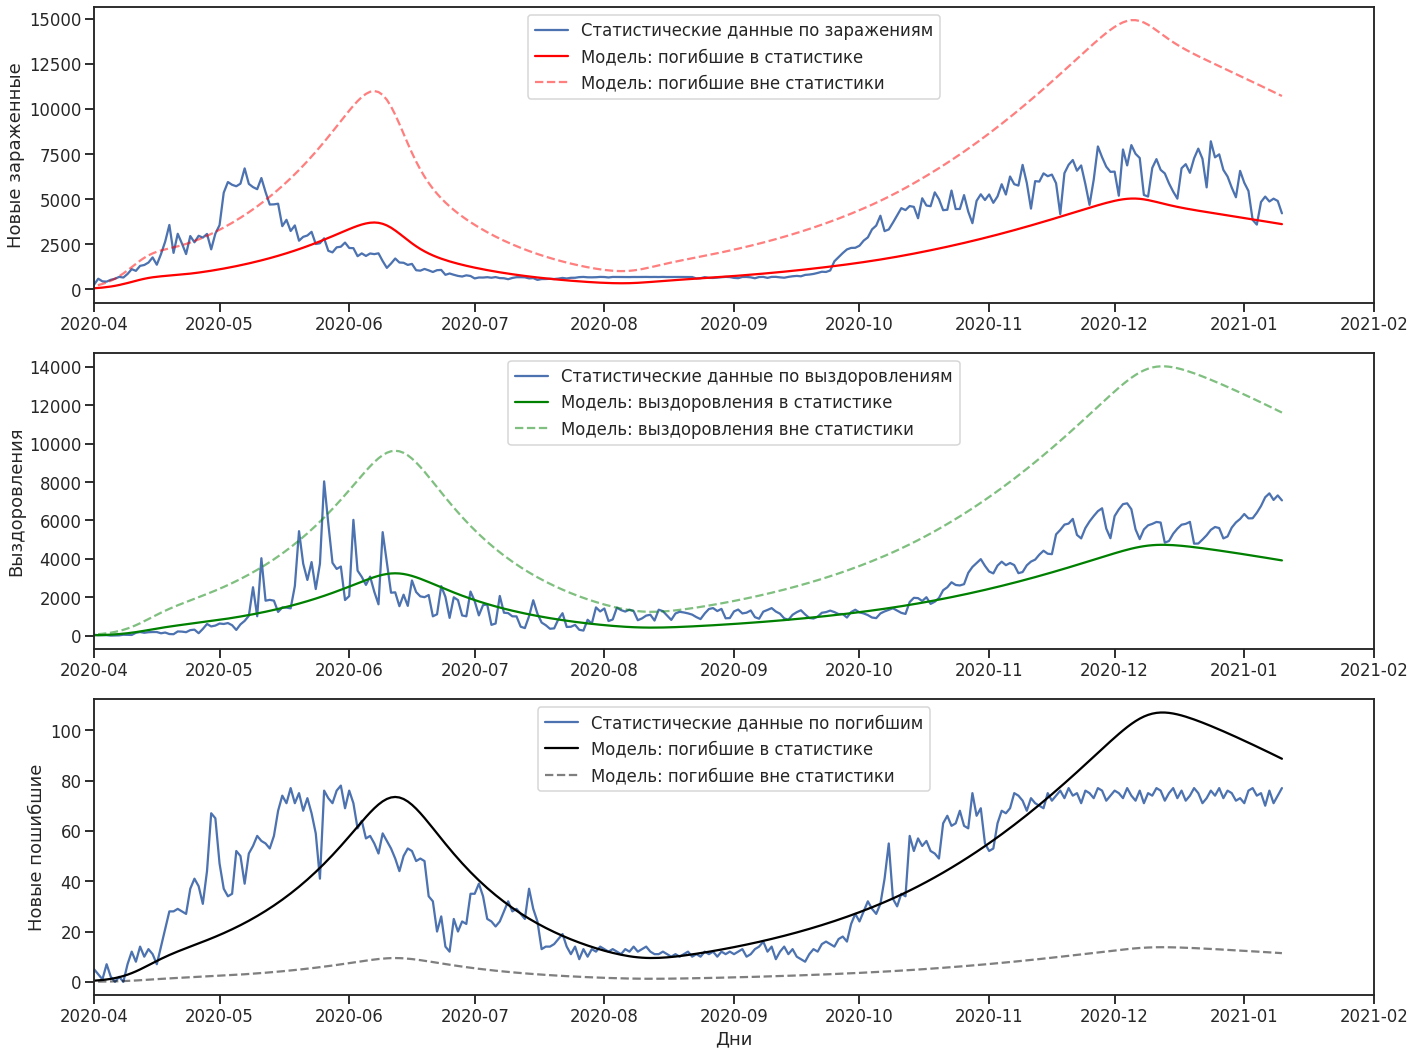

In [38]:
plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3, 1, 1)
plt.plot(train_subset.date, train_subset['infected_per_day'], label='Статистические данные по заражениям')
plt.plot(daily_df.new_infected_visible, label='Модель: погибшие в статистике', color='red', )
plt.plot(daily_df.new_infected_invisible, label='Модель: погибшие вне статистики', color='red', alpha=0.5, linestyle='dashed')
# plt.title('Новые заражения по дням')
plt.legend(loc="upper center")
plt.ylabel('Новые зараженные')
plt.xlim(pd.to_datetime('2020-04-01'), pd.to_datetime('2021-02-01'))

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='Статистические данные по выздоровлениям')
plt.plot(daily_df.new_recovered_visible, label='Модель: выздоровления в статистике', color='green', )
plt.plot(daily_df.new_recovered_invisible, label='Модель: выздоровления вне статистики', color='green', alpha=0.5, linestyle='dashed')
# plt.title('Выздоровления по дням')
plt.legend(loc="upper center")
plt.ylabel('Выздоровления')
plt.xlim(pd.to_datetime('2020-04-01'), pd.to_datetime('2021-02-01'))

plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='Статистические данные по погибшим')
plt.plot(daily_df.new_dead_visible, label='Модель: погибшие в статистике', color='black', )
plt.plot(daily_df.new_dead_invisible, label='Модель: погибшие вне статистики', color='black', alpha=0.5, linestyle='dashed')
# plt.title('Погибшие по дням')
plt.legend(loc="upper center")
plt.ylabel('Новые пошибшие')
plt.xlim(pd.to_datetime('2020-04-01'), pd.to_datetime('2021-02-01'))
plt.xlabel('Дни')

plt.tight_layout()
plt.savefig('figures/presentation/daily_infected_dead_recovered_train.png')
plt.show()

NameError: name 'eval_dates' is not defined

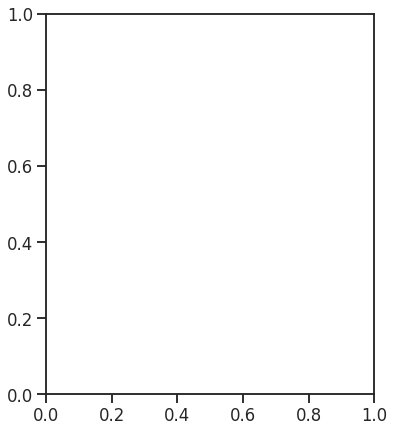

In [39]:
def plot_eval_result(ix, first=False):
    eval_date = eval_dates[ix]
    train_df = train_dfs[ix]
    test_df = test_dfs[ix]
    model_preds = model_predictions[ix]

    plt.plot(train_df.date, train_df.total_dead, label='Обучающие данные', color='black')
    plt.plot(test_df.date, test_df.total_dead, label='Тестовые данные', color='black', linestyle='dashed', alpha=0.5)
    plt.plot(test_df.date, model_preds[7], label='Прогноз', color='red',  alpha=0.5)
    plt.title(f'Дата прогноза: {str(eval_date.date())}')
    plt.axvline(x=eval_date, linestyle='dashed', alpha=0.5)
    if first:
        plt.ylabel('Суммарное число погибших')
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)

fig = plt.figure(figsize=(20, 7))

ax1 = plt.subplot(1, 3, 1)

ix = 3
plot_eval_result(ix, first=True)


plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)

ix = 10
plot_eval_result(ix)


ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ix = 13
plot_eval_result(ix)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=3)
plt.tight_layout()
fig.autofmt_xdate()
plt.savefig('figures/presentation/model_testing_results.png')
plt.show()

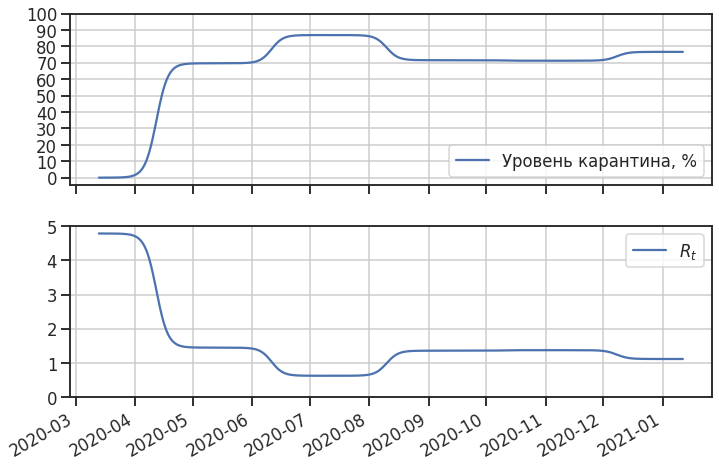

In [69]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Уровень карантина, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.savefig('figures/presentation/quarantine_function.png')
plt.show()

In [73]:
history_dates[history_dates <= pd.to_datetime('2020-10-31')]

t
1.000000     2020-03-13 00:00:00.000000000
1.000120     2020-03-13 00:00:10.342598400
1.000239     2020-03-13 00:00:20.685110400
1.000890     2020-03-13 00:01:16.863859200
1.001540     2020-03-13 00:02:13.042694400
                          ...             
229.791525   2020-10-27 18:59:47.721465600
230.622291   2020-10-28 14:56:05.931686400
231.232677   2020-10-29 05:35:03.275779200
231.843063   2020-10-29 20:14:00.619872000
232.453449   2020-10-30 10:52:57.963964800
Name: t, Length: 530, dtype: datetime64[ns]

In [77]:
history.rt.iloc[:530]

t
1.000000      4.781395
1.000120      4.781244
1.000239      4.781243
1.000890      4.781243
1.001540      4.781243
                ...   
229.791525    1.374735
230.622291    1.374742
231.232677    1.374746
231.843063    1.374749
232.453449    1.374751
Name: rt, Length: 530, dtype: float64

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]